In [43]:
MAX_EPOCHS = 500
BATCH_SIZE = 128
LEARNING_RATE = 0.001
SMILES_COL = 'Column3'
REGRESSION_COL_y = 'Column5'
REGRESSION_COL_z = 'Column10'
URL = '/home/ishii/graduation_research/data/csvファイル/dft_B3LYP_6-31G*_zinc_for-sale_1000000_0to100000.csv'

LAMDA_Y = 1
LAMDA_Z = 100000


In [28]:
#regression_col
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(self, url, smiles_col, regression_col_y, regression_col_z):
        self.max_length = 0
        self.dummy_char = '_'
        
        self.url = url
        self.smiles_col = smiles_col
        self.smiles = []
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]

        self.regression_col_y = regression_col_y
        self.regressions_y = []
        self.regression_col_z = regression_col_z
        self.regressions_z = []
        self.items = self.generate_items()
        
        self.dummmy_index = self.word_to_index[self.dummy_char]

    def load_words(self):
        train_df = pd.read_csv(self.url, usecols=[SMILES_COL])
        self.smiles = list(train_df[self.smiles_col])
        for i, smile in enumerate(self.smiles):
            new_smile = smile[1:]
            self.smiles[i] = new_smile
        self.max_length = max(len(smile) for smile in self.smiles)
        self.smiles = list(smile.ljust(self.max_length, self.dummy_char) for smile in self.smiles)
        train_df = pd.Series(self.smiles)
        text = train_df.str.cat(sep=' ')
        text = "".join(text.split(' '))
        return [text[i] for i in range(len(text))]
    
    def generate_items(self):
        train_df_y = pd.read_csv(self.url, usecols=[self.regression_col_y])
        self.regressions_y = list(train_df_y[self.regression_col_y])
        train_df_z = pd.read_csv(self.url, usecols=[self.regression_col_z])
        self.regressions_z = list(train_df_z[self.regression_col_z])
        items = []
        for i, smile in enumerate(self.smiles):
            smile = list(smile)
            items.append([self.word_to_index[w] for w in smile])
        return items

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.regressions_y)

    def __getitem__(self, index):
        return (
            torch.tensor(self.items[index]),
            torch.tensor(self.regressions_y[index]),
            torch.tensor(self.regressions_z[index])
        )

In [29]:
#変更後のモデル
import torch

class LSTM_Predictor(torch.nn.Module):
    def __init__(self, dataset):
        super(LSTM_Predictor, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = torch.nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
            #padding_idxの処理が不明確
            #padding_idx=dataset.dummmy_index
        )
        self.lstm = torch.nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=0.2,
        )
        self.fc = torch.nn.Linear(self.lstm_size, 2)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.lstm_size),
                torch.zeros(self.num_layers, batch_size, self.lstm_size))

In [30]:
#変更後の訓練プロセス
import torch
import numpy as np

def train(dataset, train_dataset, model):
    train_losses = []
    val_losses = []
    
    train_losses_y = []
    val_losses_y = []
    
    train_losses_z = []
    val_losses_z = []
    
    
    lamda_y = LAMDA_Y
    lamda_z = LAMDA_Z
    
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    for epoch in range(MAX_EPOCHS):
        model.train()
        
        state_h, state_c = model.init_state(BATCH_SIZE)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        
        
        total_train_loss = 0
        total_val_loss = 0
        
        total_train_loss_y = 0
        total_val_loss_y = 0

        total_train_loss_z = 0
        total_val_loss_z = 0
        
        

        for batch, (x, y, z) in enumerate(train_dataloader):
            if batch < int(len(train_dataloader) * 0.75):
                model.train()
                
                optimizer.zero_grad()
                
                output, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                output_permute = torch.permute(output, (2, 1, 0))
                
                train_loss_y = criterion(output_permute[0][dataset.max_length-1], y.to(device))
                total_train_loss_y += train_loss_y.item()
                train_loss_z = criterion(output_permute[1][dataset.max_length-1], z.to(device))
                total_train_loss_z += train_loss_z.item()
                
                
                train_loss = lamda_y*train_loss_y + lamda_z*train_loss_z
                total_train_loss += train_loss.item()
                

                state_h = state_h.detach()
                state_c = state_c.detach()

                train_loss.backward()
                optimizer.step()
                
            else:
                model.eval()
                
                output, (state_h, state_c) = model(x.to(device), (state_h, state_c))
                output_permute = torch.permute(output, (2, 1, 0))
                
                val_loss_y = criterion(output_permute[0][dataset.max_length-1], y.to(device))
                total_val_loss_y += val_loss_y.item()
                val_loss_z = criterion(output_permute[1][dataset.max_length-1], z.to(device))
                total_val_loss_z += val_loss_z.item()

                val_loss = lamda_y*val_loss_y + lamda_z*val_loss_z
                total_val_loss += val_loss.item()                
                
                
                state_h = state_h.detach()
                state_c = state_c.detach()
        
        #scheduler.step()
        
        average_total_loss = total_train_loss / int(len(train_dataloader) * 0.75)
        average_total_val_loss = total_val_loss / (len(train_dataloader) - int(len(train_dataloader) * 0.75))
        
        average_total_loss_y = total_train_loss_y / int(len(train_dataloader) * 0.75)
        average_total_val_loss_y = total_val_loss_y / (len(train_dataloader) - int(len(train_dataloader) * 0.75))

        average_total_loss_z = total_train_loss_z / int(len(train_dataloader) * 0.75)
        average_total_val_loss_z = total_val_loss_z / (len(train_dataloader) - int(len(train_dataloader) * 0.75))        
        
        print("Epoch: {}, train_Loss: {:.3f}, val_Loss: {:.3f}, train_Loss_y: {:.3f}, val_Loss_y: {:.3f}, train_Loss_z:{:.3f}, val_Loss_z:{:.3f}".format(
            epoch+1, 
            average_total_loss,
            average_total_val_loss,
            average_total_loss_y,
            average_total_val_loss_y,
            average_total_loss_z,
            average_total_val_loss_z
        ))
        
        train_losses.append(average_total_loss)
        val_losses.append(average_total_val_loss)
        train_losses_y.append(average_total_loss_y)
        val_losses_y.append(average_total_val_loss_y)
        train_losses_z.append(average_total_loss_z)
        val_losses_z.append(average_total_val_loss_z)
        
    return train_losses, val_losses, train_losses_y, val_losses_y, train_losses_z, val_losses_z

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: " + str(device) + '\n')


device: cuda:0



In [32]:
dataset = Dataset(url=URL, smiles_col=SMILES_COL, regression_col_y=REGRESSION_COL_y, regression_col_z=REGRESSION_COL_z)
n_samples = len(dataset)
indices = list(range(n_samples))
train_size = int(n_samples * 0.8)
test_size = n_samples - train_size

train_dataset = torch.utils.data.Subset(dataset, indices[:train_size])
test_dataset = torch.utils.data.Subset(dataset, indices[train_size:])

print(len(train_dataset))
print(len(test_dataset))


70102
17526


In [33]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)
print(int(len(train_dataloader) * 0.75))
print(len(train_dataloader) - int(len(train_dataloader) * 0.75))

410
137


In [34]:
model = LSTM_Predictor(dataset)
model = model.to(device)
train_losses, val_losses, train_losses_y, val_losses_y, train_losses_z, val_losses_z = train(dataset, train_dataset, model)

Epoch: 1, train_Loss: 252904.180, val_Loss: 221401.919, train_Loss_y: 94843.662, val_Loss_y: 81179.209, train_Loss_z:1.581, val_Loss_z:1.402
Epoch: 2, train_Loss: 226631.734, val_Loss: 196748.986, train_Loss_y: 70608.480, val_Loss_y: 56376.202, train_Loss_z:1.560, val_Loss_z:1.404
Epoch: 3, train_Loss: 205578.804, val_Loss: 180577.048, train_Loss_y: 49579.060, val_Loss_y: 39996.411, train_Loss_z:1.560, val_Loss_z:1.406
Epoch: 4, train_Loss: 191232.548, val_Loss: 168266.120, train_Loss_y: 35228.484, val_Loss_y: 27773.507, train_Loss_z:1.560, val_Loss_z:1.405
Epoch: 5, train_Loss: 180563.852, val_Loss: 159180.525, train_Loss_y: 24536.551, val_Loss_y: 18621.503, train_Loss_z:1.560, val_Loss_z:1.406
Epoch: 6, train_Loss: 172458.861, val_Loss: 153010.493, train_Loss_y: 16479.915, val_Loss_y: 12302.137, train_Loss_z:1.560, val_Loss_z:1.407
Epoch: 7, train_Loss: 167123.360, val_Loss: 148770.410, train_Loss_y: 11141.013, val_Loss_y: 8066.637, train_Loss_z:1.560, val_Loss_z:1.407
Epoch: 8, trai

In [133]:
def predect(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=5, drop_last=True)

    index = np.random.choice(len(test_dataloader))
    
    for batch, (x, y, z) in enumerate(test_dataloader):
    
        smiles, y, z = x, y, z
        break
    state_h, state_c = model.init_state(5)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    output, (state_h, state_c) = model(smiles.to(device), (state_h, state_c))
    output_permute = torch.permute(output, (2, 1, 0))    

    print(output_permute)
    print(y)
    print(z)

In [127]:
predect(dataset, test_dataset, model)

tensor([[[-0.0726, -0.1839, -0.1839, -0.1839, -0.1839],
         [-0.1162, -0.5293, -0.7402, -0.5293, -0.5293],
         [-0.2724, -1.0068, -1.3992, -1.0068, -1.1366],
         [-0.5556, -1.4714, -1.7319, -1.4714, -1.6050],
         [-1.0207, -1.7217, -1.8202, -1.7217, -1.7867],
         [-1.4371, -1.8110, -1.8385, -1.8110, -1.8313],
         [-1.6880, -1.8355, -1.8421, -1.8355, -1.8406],
         [-1.7950, -1.8413, -1.8428, -1.8413, -1.8425],
         [-1.8289, -1.8426, -1.8430, -1.8426, -1.8429],
         [-1.8391, -1.8429, -1.8430, -1.8429, -1.8430],
         [-1.8420, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8427, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8429, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1.8430],
         [-1.8430, -1.8430, -1.8430, -1.8430, -1

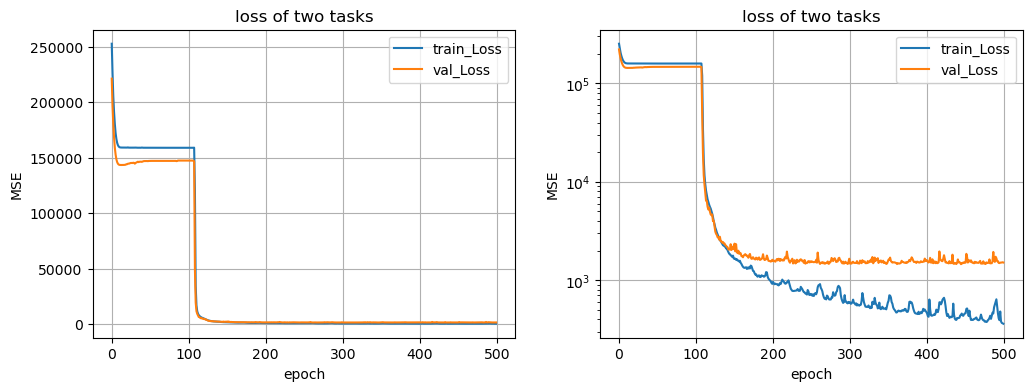

In [42]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(train_losses, label="train_Loss")
axes[0].plot(val_losses, label="val_Loss")
axes[0].set_title("loss of two tasks")
axes[0].grid()
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].plot(train_losses, label="train_Loss")
axes[1].plot(val_losses, label="val_Loss")
axes[1].set_title("loss of two tasks")
axes[1].grid()
axes[1].set_yscale('log')
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("MSE")
axes[1].legend()


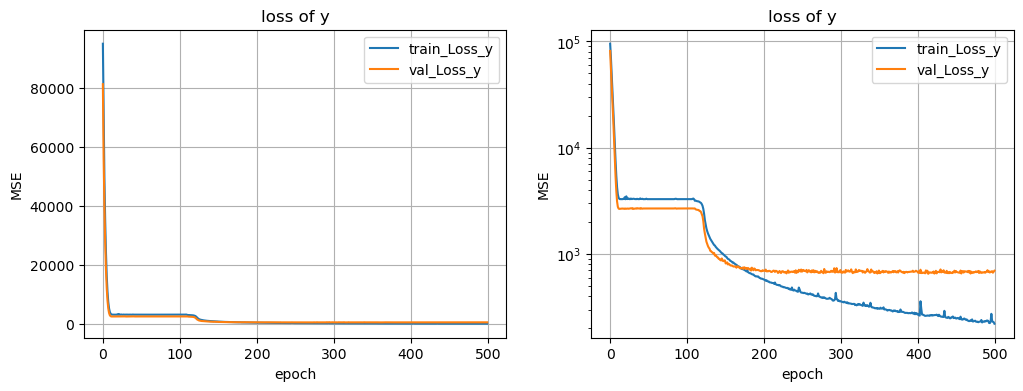

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(train_losses_y, label="train_Loss_y")
axes[0].plot(val_losses_y, label="val_Loss_y")
axes[0].set_title("loss of y")
axes[0].grid()
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].plot(train_losses_y, label="train_Loss_y")
axes[1].plot(val_losses_y, label="val_Loss_y")
axes[1].set_title("loss of y")
axes[1].grid()
axes[1].set_yscale('log')
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("MSE")
axes[1].legend()

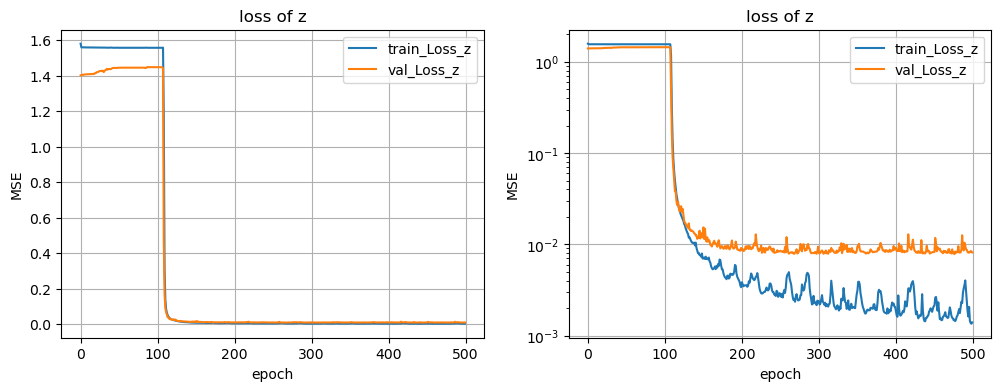

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
axes[0].plot(train_losses_z, label="train_Loss_z")
axes[0].plot(val_losses_z, label="val_Loss_z")
axes[0].set_title("loss of z")
axes[0].grid()
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("MSE")
axes[0].legend()

axes[1].plot(train_losses_z, label="train_Loss_z")
axes[1].plot(val_losses_z, label="val_Loss_z")
axes[1].set_title("loss of z")
axes[1].grid()
axes[1].set_yscale('log')
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("MSE")
axes[1].legend()

In [55]:
def test(dataset, test_dataset, model):
    model.eval()
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    batch_size = 1
    
    lamda_y = LAMDA_Y
    lamda_z = LAMDA_Z    
    
    
    output_y = []
    output_z = []
    label_y = []
    label_z = []
    

    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)
    
    criterion = torch.nn.L1Loss()
    
    total_test_loss = 0
    total_test_loss_y = 0
    total_test_loss_z = 0
    
    state_h, state_c = model.init_state(batch_size)
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    
    for batch, (x, y, z) in enumerate(test_dataloader):
    
        output, (state_h, state_c) = model(x.to(device), (state_h, state_c))
        output_permute = torch.permute(output, (2, 1, 0))    
        test_loss_y = criterion(output_permute[0][dataset.max_length-1], y.to(device))
        test_loss_z = criterion(output_permute[1][dataset.max_length-1], z.to(device))
        test_loss = lamda_y*test_loss_y + lamda_z*test_loss_z
        
        total_test_loss += test_loss.item()
        total_test_loss_y += test_loss_y.item()
        total_test_loss_z += test_loss_z.item()

        state_h = state_h.detach()
        state_c = state_c.detach()
        
        
        output_y.append(output_permute[0][dataset.max_length-1].cpu().detach().numpy())
        output_z.append(output_permute[1][dataset.max_length-1].cpu().detach().numpy())
        label_y.append(y.cpu().detach().numpy())
        label_z.append(z.cpu().detach().numpy())
        
    
    average_total_loss = total_test_loss / len(test_dataloader)
    average_total_loss_y = total_test_loss_y / len(test_dataloader)
    average_total_loss_z = total_test_loss_z / len(test_dataloader)
    
    return average_total_loss, average_total_loss_y, average_total_loss_z, output_y, output_z, label_y, label_z
        

In [56]:
average_total_loss, average_total_loss_y, average_total_loss_z, output_y, output_z, label_y, label_z = test(dataset, test_dataset, model)

print("test_Loss: {:.3f}".format(average_total_loss))
print("test_Loss_y: {:.3f}".format(average_total_loss_y))
print("test_Loss_z: {:.3f}".format(average_total_loss_z))


test_Loss: 6628.091
test_Loss_y: 18.880
test_Loss_z: 0.066


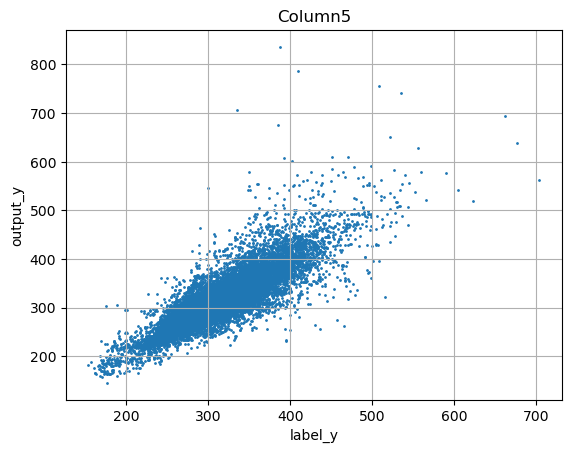

In [57]:

import matplotlib.pyplot as plt
plt.scatter(output_y, label_y, s=1)
plt.title(REGRESSION_COL_y)
plt.xlabel("label_y")
plt.ylabel("output_y")
plt.grid(True)

plt.show()

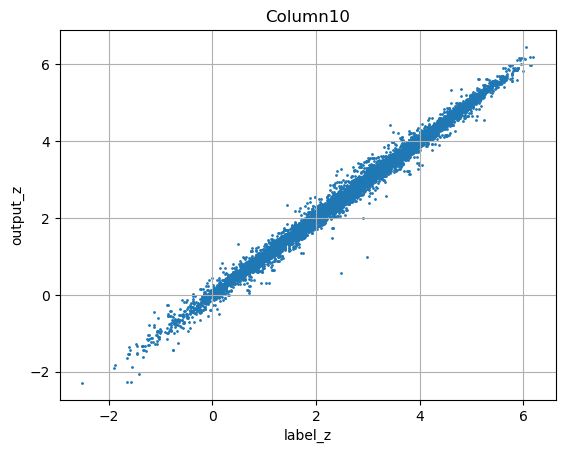

In [58]:
plt.scatter(output_z, label_z, s=1)
plt.title(REGRESSION_COL_z)
plt.xlabel("label_z")
plt.ylabel("output_z")
plt.grid(True)

plt.show()